In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from pylab import *

import aesara.tensor as at
import aesara.tensor.extra_ops as ate
import arviz as az
import astropy.cosmology as cosmo
import astropy.units as u
import pymc as pm
import scipy.integrate as si
import seaborn as sns

sns.set_context('notebook')

In [3]:
def at_interp(x, xs, ys):
    x = at.as_tensor(x)
    xs = at.as_tensor(xs)
    ys = at.as_tensor(ys)

    ind = ate.searchsorted(xs, x)
    r = (x - xs[ind-1])/(xs[ind]-xs[ind-1])
    return r*ys[ind] + (1-r)*ys[ind-1]

In [4]:
def Ez(z, Om, w):
    opz = 1 + z
    return at.sqrt(Om*opz*opz*opz + (1-Om)*opz**(3*(1+w)))

def dCs(zs, Om, w):
    dz = zs[1:] - zs[:-1]
    fz = 1/Ez(zs, Om, w)
    I = 0.5*dz*(fz[:-1] + fz[1:])
    return at.concatenate([at.as_tensor([0.0]), at.cumsum(I)])

def dLs(zs, dCs):
    return dCs*(1+zs)

In [5]:
def make_model(zs_obs, sigma_zs_obs, dls_obs, sigma_dls_obs, zmax=100):
    zinterp = expm1(linspace(log(1), log(1+zmax), 1024))

    with pm.Model() as model:
        h = pm.Uniform('h', 0.35, 1.4, initval=0.7)
        Om = pm.Uniform('Om', 0, 1, initval=0.3)
        w = pm.Uniform('w', -1.5, -0.5, initval=-1)
        Ode = pm.Deterministic('Ode', 1-Om)
        dH = pm.Deterministic('dH', 2.99792 / h) # Gpc

        dCinterp = dH*dCs(zinterp, Om, w)
        dLinterp = dLs(zinterp, dCinterp)
        dVCinterp = 4*pi*dCinterp*dCinterp*dH/Ez(zinterp, Om, w)

        zden = (1+zinterp)**1.7 / (1 + ((1+zinterp)/(1+1.9))**5.6) * dVCinterp
        norm = 0.5*at.sum((zinterp[1:] - zinterp[:-1])*(zden[1:] + zden[:-1]))
        log_norm = at.log(norm)

        z = pm.Uniform('z', 0, zmax, initval=zs_obs, shape=zs_obs.shape[0])
        pm.Potential('zprior', at.sum(1.7*at.log1p(z) - at.log1p(((1+z)/(1+1.9))**5.6) + at.log(at_interp(z, zinterp, dVCinterp)) - log_norm)) # SFR / (1+z)

        dL = pm.Deterministic('dL', at_interp(z, zinterp, dLinterp))

        pm.Normal('z_likelihood', mu=z, sigma=sigma_zs_obs, observed=zs_obs)
        pm.Normal('dL_likelihood', mu=dL, sigma=sigma_dls_obs, observed=dls_obs)
    return model

Text(0, 0.5, '$p(z)$')

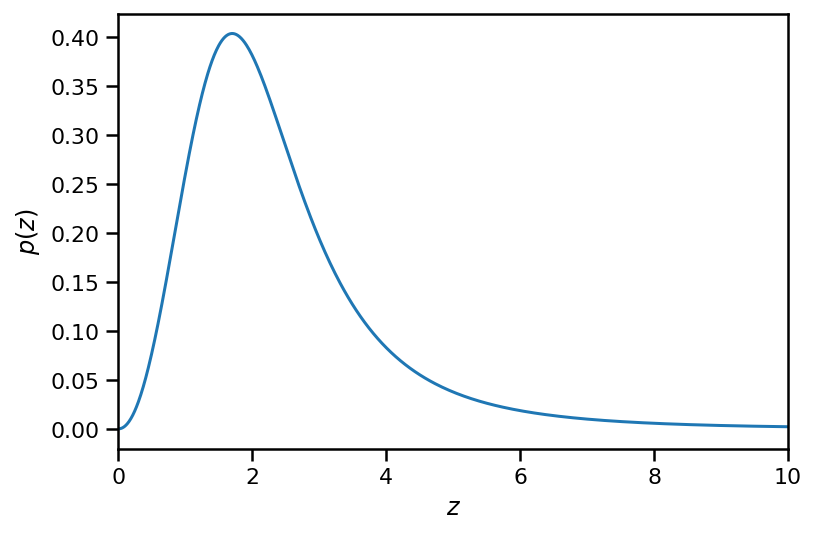

In [6]:
zi = expm1(linspace(log(1), log(1+100), 1024))
pz = (1+zi)**1.7/(1+((1+zi)/(1+1.9))**5.6)*cosmo.Planck18.differential_comoving_volume(zi).to(u.Gpc**3/u.sr)
cz = si.cumulative_trapezoid(pz, zi, initial=0)
plot(zi, pz/cz[-1])
axis(xmin=0, xmax=10)
xlabel(r'$z$')
ylabel(r'$p(z)$')

Text(0.5, 8.95999999999998, '$z$')

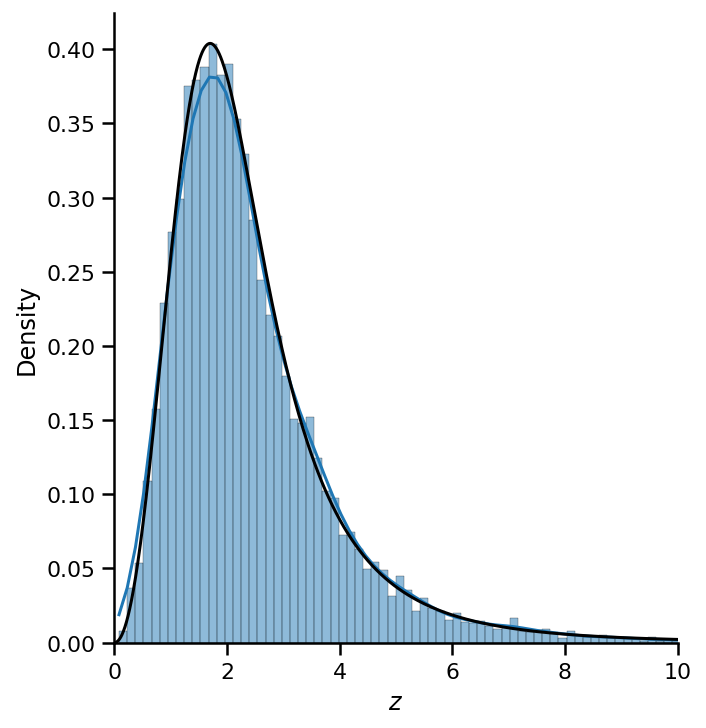

In [12]:
Nobs = 10000
zt = np.interp(np.random.uniform(low=0, high=cz[-1], size=Nobs), cz, zi)
dt = cosmo.Planck18.luminosity_distance(zt).to(u.Gpc).value
sns.displot(zt, kde=True, stat='density')
plot(zi, pz/cz[-1], color='k')
axis(xmin=0, xmax=10)
xlabel(r'$z$')

In [13]:
sigma_z = 0.1*ones(Nobs)
sigma_d = 0.1*dt
zo = zt + sigma_z*randn(Nobs)
do = dt + sigma_d*randn(Nobs)

In [14]:
model = make_model(zo, sigma_z, do, sigma_d)

In [15]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/wfarr/miniconda3/envs/PymcCosmography/lib/python3.10/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [h, Om, w, z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1245 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


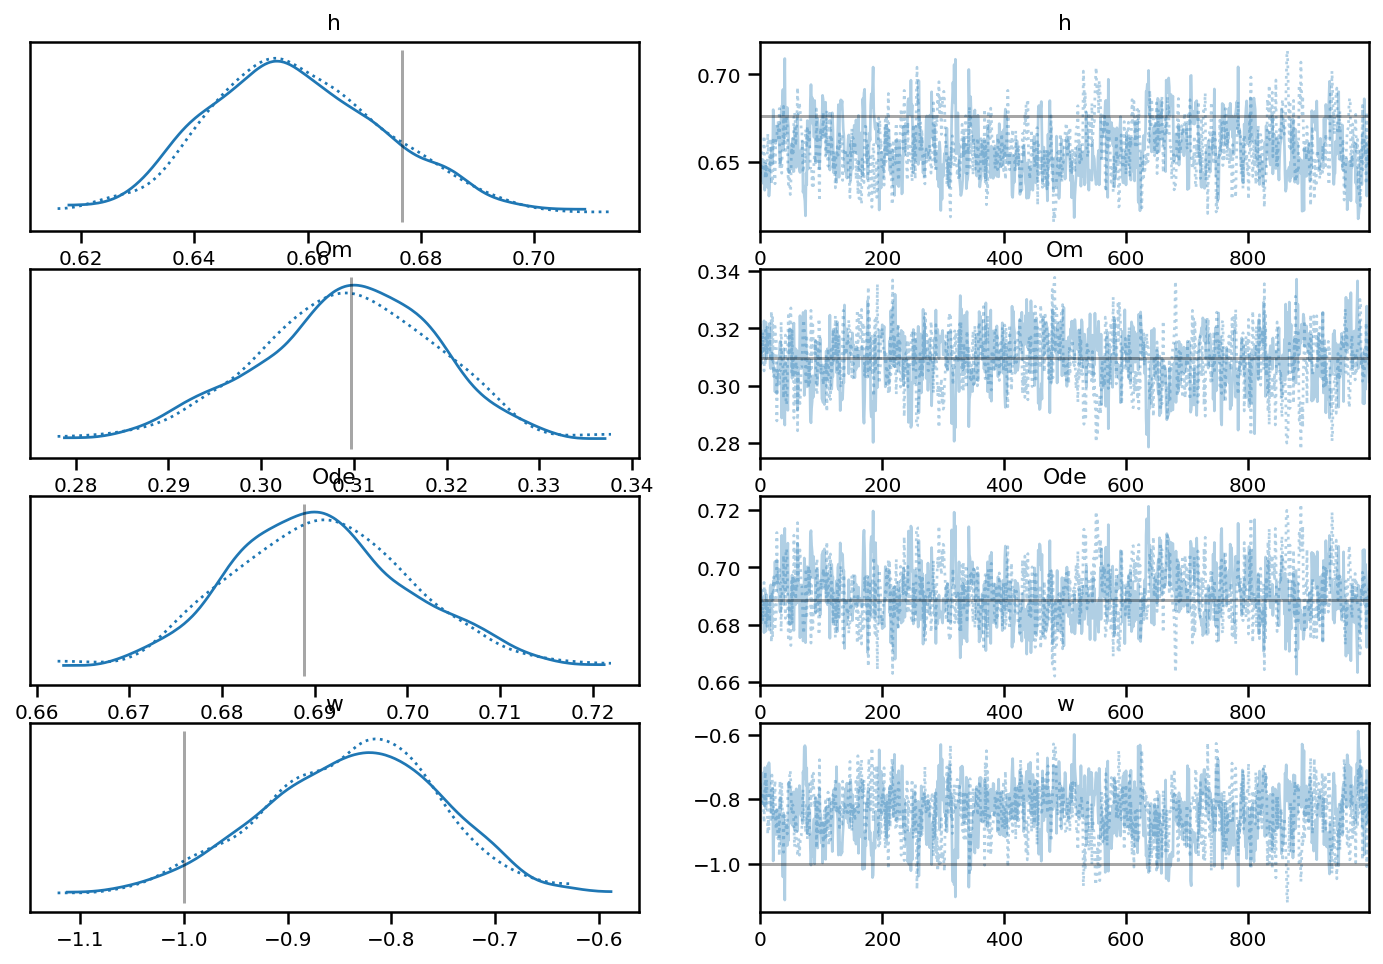

In [16]:
with model:
    az.plot_trace(trace, compact=True, var_names=['h', 'Om', 'Ode', 'w'],
                  lines=[('h', {}, cosmo.Planck18.H0/100),
                         ('Om', {}, cosmo.Planck18.Om0),
                         ('Ode', {}, cosmo.Planck18.Ode0),
                         ('w', {}, -1)])

array([[<AxesSubplot:ylabel='h'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='Om'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='h', ylabel='w'>, <AxesSubplot:xlabel='Om'>,
        <AxesSubplot:xlabel='w'>]], dtype=object)

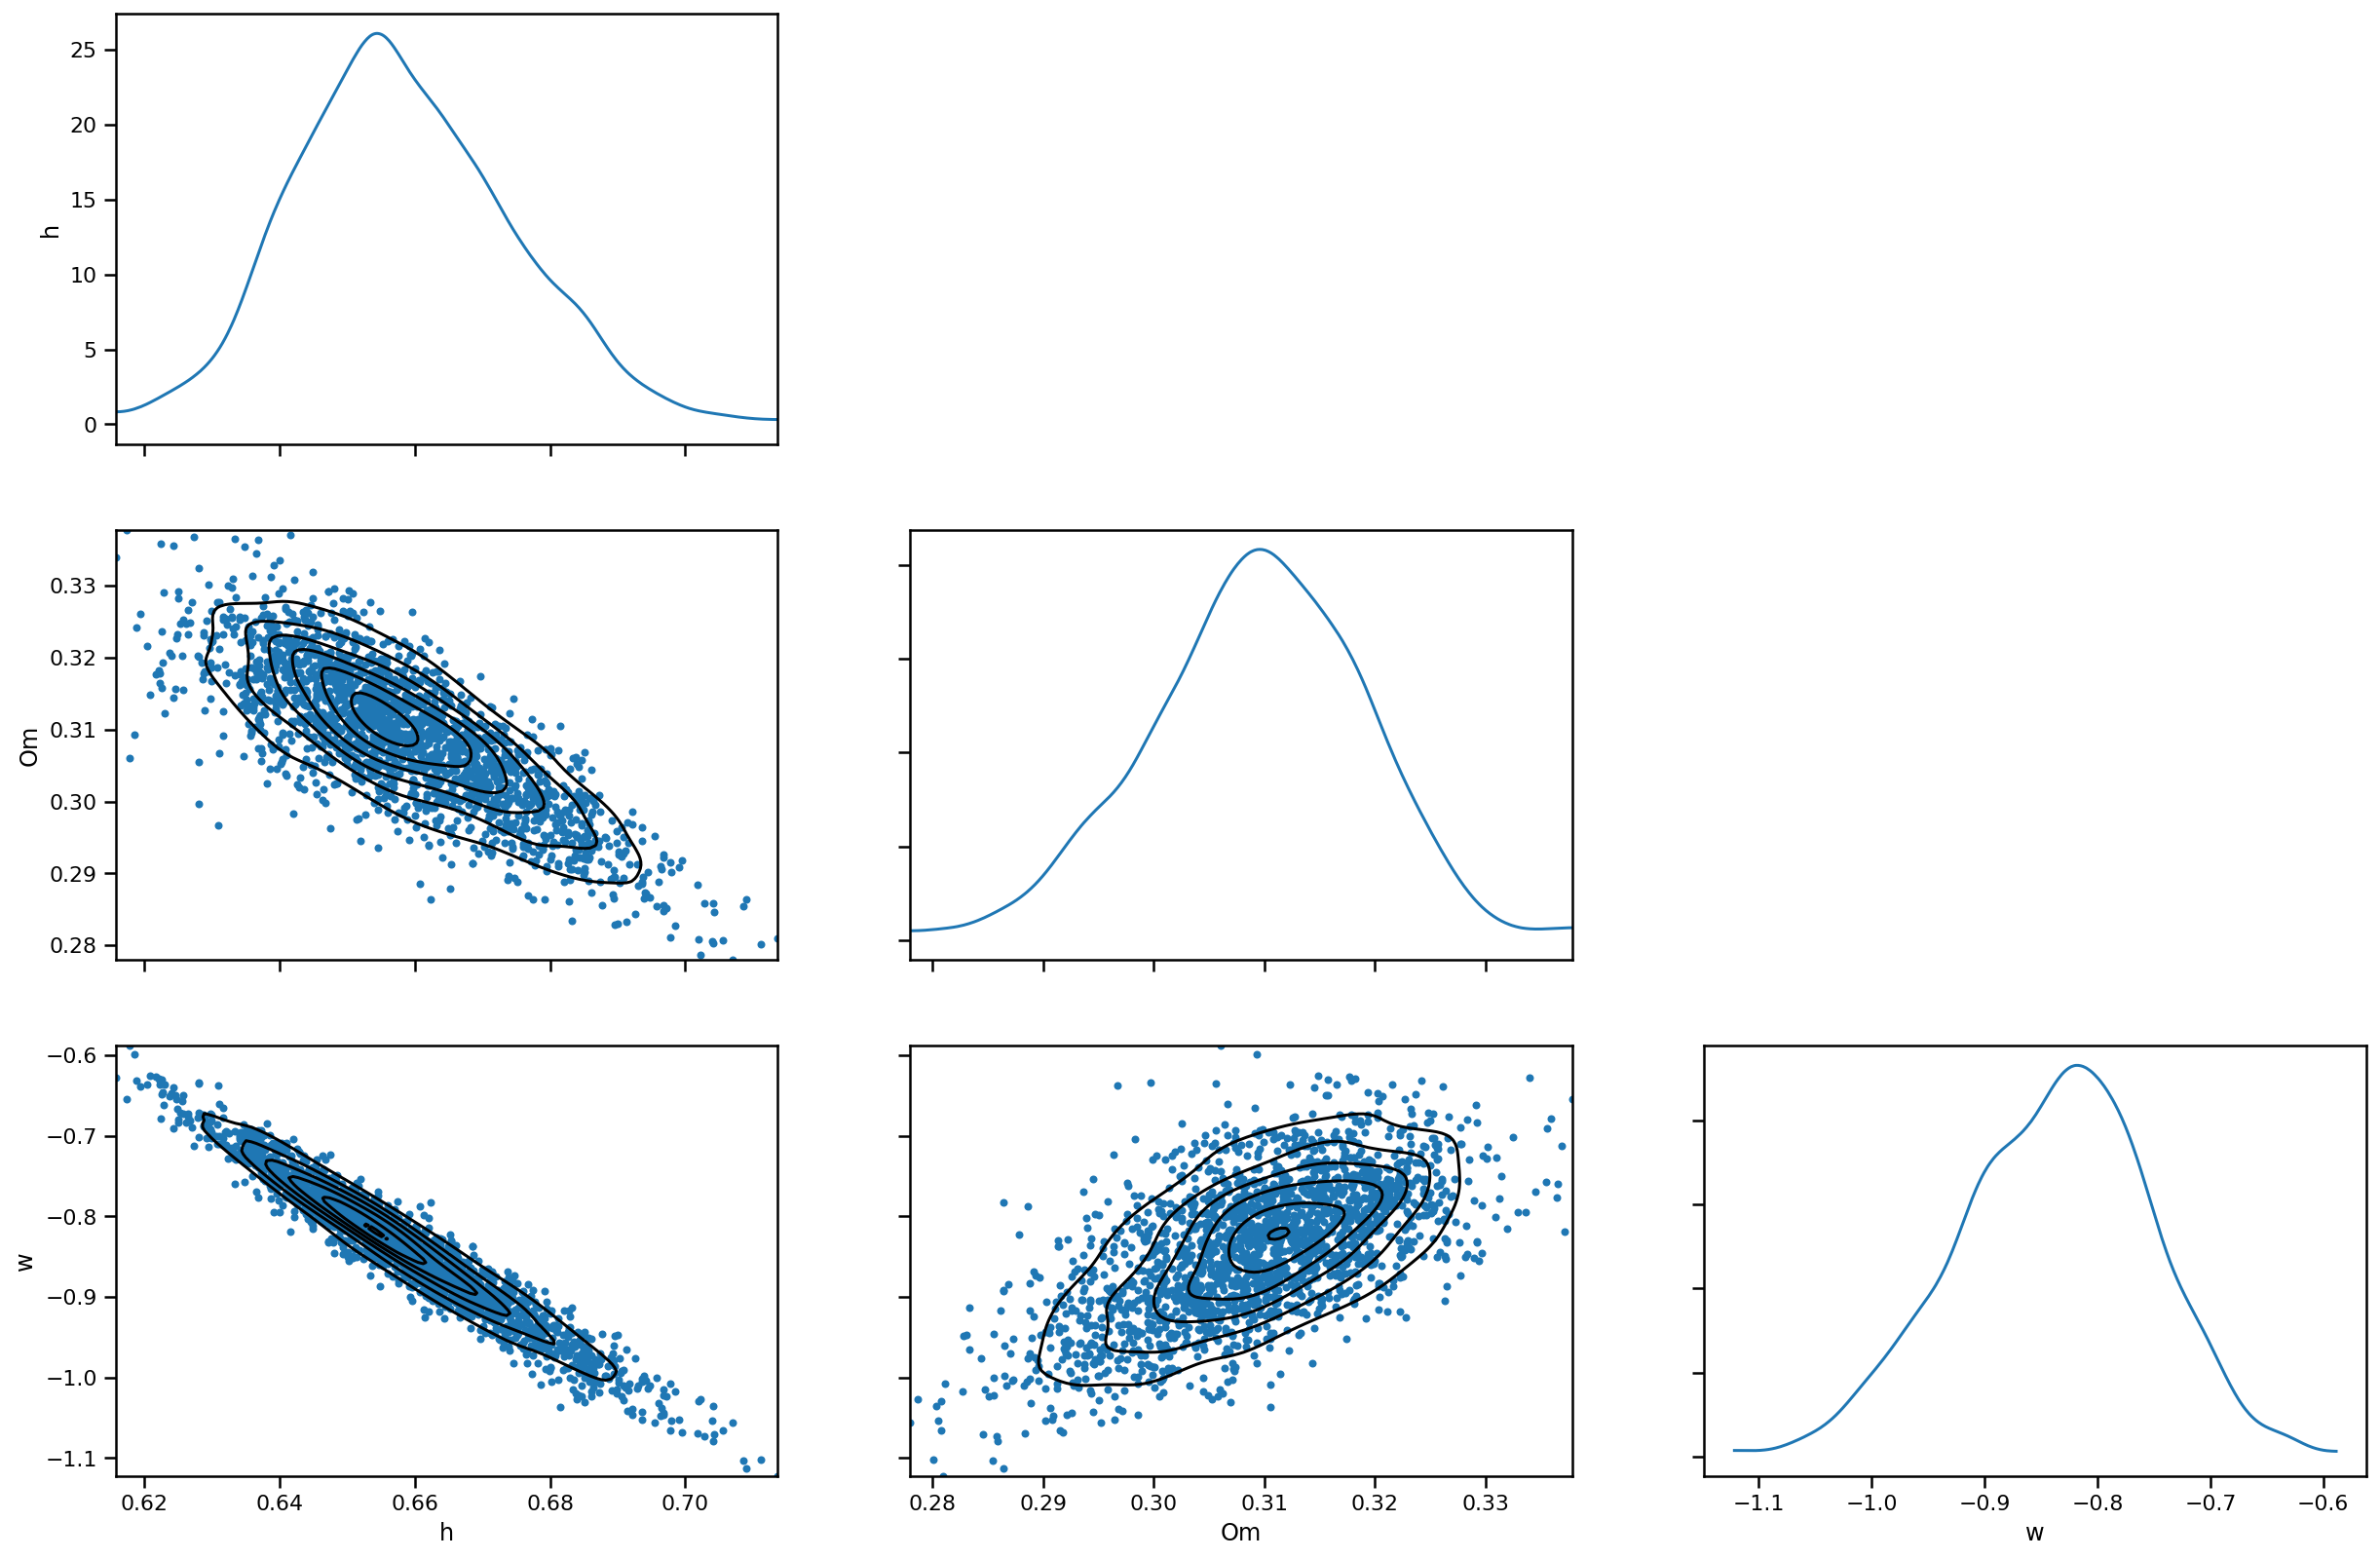

In [20]:
az.plot_pair(trace, var_names=['h', 'Om', 'w'], marginals=True, kind=['scatter', 'kde'])